I have been working with a team of 3 called *__InnerPigDog__*. We worked remotely using git to share code (https://github.com/tcoppotelli/PredictFutureSales).  
After the initial project setup, EDA and few experiments we decided to move to a kaggle kernel and take advantage of the free GPU access.  
I've tried to obtimise my XGBoost model adding more features and doing more hyperparameter optimisation while Vitaliy focused on a lightgbm model.  
Turned out his model was slightly better than mine but we both managed to achieve 10/10 on the private set valuation.  
You can run this Notebook from beginning to end. I have provided a precomputed model ```model.pickle.dat``` that you can run if you want to reproduce the results. Training this model without GPU is a quite slow.

There is an incredible quantity of learning material and I have been able to learn from every kernel I've read. I was new to the concept of EDA and it was quite interesting to have a look at different approaches. 

I want to mention few notebooks that helped me:
1. (https://www.kaggle.com/python10pm/future-sales-part-i-eda) best place to start with EDA
2. (https://www.kaggle.com/noahfinberg/eda-previous-value-benchmark/notebook#EDA-&-Previous-Value-Benchmark) has an interesting different approach to EDA, using a library for doing an automatic EDA.
3. (https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda) contains interesting material on stacking 
4. (https://www.kaggle.com/python10pm/plotting-with-python-learn-80-plots-step-by-step) is a very nice introduction to plotting



# Predict Future Sales

We are assuming that the train and test data are here '/kaggle/input/competitive-data-science-predict-future-sales/'

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import gc
import pickle
from itertools import product
from tqdm import tqdm_notebook
import xgboost as xgb
from xgboost import plot_importance
import time
from calendar import monthrange
from datetime import date, timedelta
import shap
from ipywidgets import IntProgress
#if you receive an error while running tqdm_notebook you need to install ipywidgets
#!pip install ipywidgets
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

# EDA and Data preparation

We are first going to have a look at the data for training. We need to predict the total number of items sold in a shop over a month.
Let's look at what the data can tell us by looking at each data source separately.

## Shops

In [2]:
shops = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [3]:
shops[shops.shop_id.isin([0,57,1,58,11,10,40,39,23,24])]

shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
23                 Москва ТК "Буденовский" (пав.А2)       23
24                 Москва ТК "Буденовский" (пав.К7)       24
39            РостовНаДону ТРК "Мегацентр Горизонт"       39
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40
57                          Якутск Орджоникидзе, 56       57
58                          Якутск ТЦ "Центральный"       58

We know by looking at the data that there are 5 duplicated shops (0 and 57, 1 and 58, 11 and 10, 40 and 39 and 23 and 24).  
We also know that we can use ТЦ,ТК,ТРЦ and ТРК to identify different types of shops and that we can extract the city where the shop is from the shop name.  
Finally, we know that Moscow and Saint Petersburg are very different from the rest of the country.  
We decided to create new features based on this information.

In [4]:
def extract_shop_type(df):
    'Extracts type of the shop and creates the shop_type_1 and shop_type_2 columns'

    df.loc[df['shop_name'].str.contains('ТЦ'),'shop_type_1'] = 'type_1'
    df.loc[df['shop_name'].str.contains('ТК'),'shop_type_1'] = 'type_2'
    df.loc[df['shop_name'].str.contains('ТРЦ'),'shop_type_1'] = 'type_3'
    df.loc[df['shop_name'].str.contains('ТРК'),'shop_type_1'] = 'type_4'

    df.loc[(df['shop_name'].str.contains('ТЦ')) |
           (df['shop_name'].str.contains('ТК')),'shop_type_2'] = 'type_1'
    df.loc[(df['shop_name'].str.contains('ТРЦ')) |
           (df['shop_name'].str.contains('ТРК')),'shop_type_2'] = 'type_2'

    df.shop_type_1 = df.shop_type_1.fillna('NONE')
    df.shop_type_2 = df.shop_type_2.fillna('NONE')

    le_1 = preprocessing.OrdinalEncoder(dtype=np.int32)
    df['shop_type_1'] = le_1.fit_transform(df[['shop_type_1']])
    le_2 = preprocessing.OrdinalEncoder(dtype=np.int32)
    df['shop_type_2'] = le_2.fit_transform(df[['shop_type_2']])

    return df


def extract_shop_city(df):
    'Extracts shop city name and city type and creates two new columns'

    # City type: 1 if city is Moscow or Sankt Petersburg (they are quite different from the rest of Russia)
    df['shop_city_type'] = 0

    df['shop_city'] = df['shop_name'].str.split(' ').str[0]
    df.drop(columns=['shop_name'], inplace=True)

    df.loc[df['shop_city'].isin(['Москва', 'СПб']), 'shop_city_type'] = 1

    le = preprocessing.OrdinalEncoder(dtype=np.int32)
    df['shop_city'] = le.fit_transform(df[['shop_city']])

    return df


def fix_shops(shops_df):
    """
    This function modifies the shops df inplace.
    It correct's 3 shops that we have found to be 'duplicates'
    and also creates a few more features: extracts the city and encodes it using OrdinalEncoder
    """

    shops_df = shops_df.loc[~shops_df['shop_id'].isin([0, 1, 11, 40, 23])]
    shops_df = extract_shop_type(shops_df)
    shops_df = extract_shop_city(shops_df)

    return shops_df

shops = fix_shops(shops)
shops.head()

/Users/tullioc/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tullioc/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/tullioc/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

shop_id  shop_type_1  shop_type_2  shop_city_type  shop_city
2        2            1            1               0          0
3        3            4            2               0          1
4        4            1            1               0          2
5        5            3            2               0          3
6        6            0            0               0          4

## Sales

In [5]:
sales = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
sales.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

<Figure size 720x288 with 0 Axes>

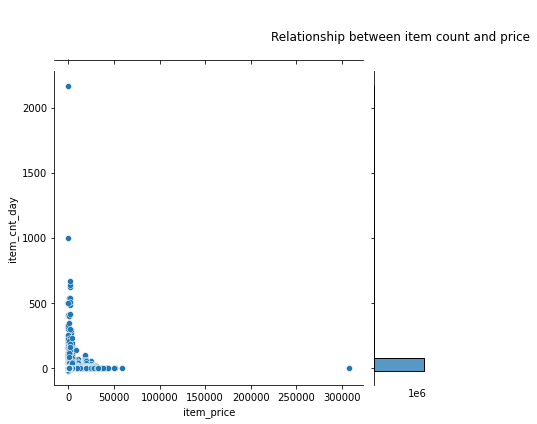

In [6]:
def show_plt():
    plt.figure(figsize = (10,4))
    sns.jointplot(x = "item_price", y = "item_cnt_day", data = sales);
    plt.title("Relationship between item count and price", y=1.08)
show_plt()

We can notice that there are only few items that cost a lot and only few items that are sold very often. We can remove outliers and keep 99% of the data. Let's see what is the impact

In [7]:
def remove_outliers(df):
    return df[(df["item_price"] < np.percentile(df["item_price"], q=99))
              & (df["item_price"] > 0)
              & (df["item_cnt_day"] >= 0)
              & (df["item_cnt_day"] < np.percentile(df["item_cnt_day"], q=99))]

In [8]:
sales = remove_outliers(sales)

<Figure size 1008x288 with 0 Axes>

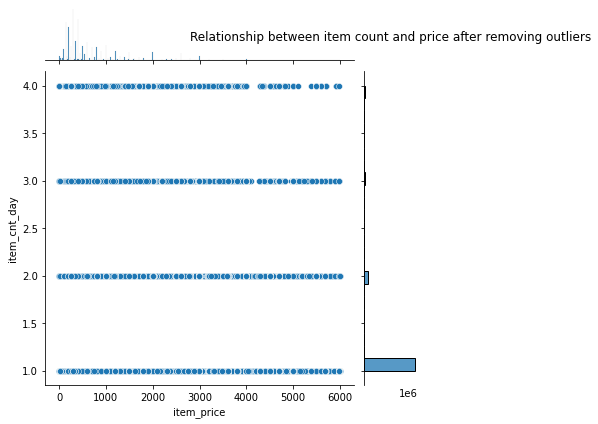

In [9]:
def show_plt(sales):    
    plt.figure(figsize = (14,4))
    sns.jointplot(x = "item_price", y = "item_cnt_day", data = sales);
    plt.title("Relationship between item count and price after removing outliers", y=1.08)
show_plt(sales)  

Most items are not sold very often. We will keep the filtered dataset.  
It is worth noting that I tried several alternatives for outliers including no outliers and removing just everything that was over 30000. They all produced worse results.

In [10]:
def adjust_duplicated_shops(df):

    df.loc[df['shop_id'] == 0, 'shop_id'] = 57
    df.loc[df['shop_id'] == 1, 'shop_id'] = 58
    df.loc[df['shop_id'] == 11, 'shop_id'] = 10
    df.loc[df['shop_id'] == 40, 'shop_id'] = 39
    df.loc[df['shop_id'] == 23, 'shop_id'] = 24

    return df
sales = adjust_duplicated_shops(sales)

Let's have a look at some different aggregation of sales data (after adjusting for duplicated shops).
We will also add more aggregations as explained in week 4 assignments. We want to know the total number of items sold in a shop per month and the total number of times an item is sold across the country. This approach is also known as __Mean Encoding__. If you were to use this information to train the model you will get a very good score... just to realise that you cannot use this value to predict on test dataset. Yes I did do that mistake :) Lesson learned, you do need to implement lag

/Users/tullioc/.pyenv/versions/3.7.9/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


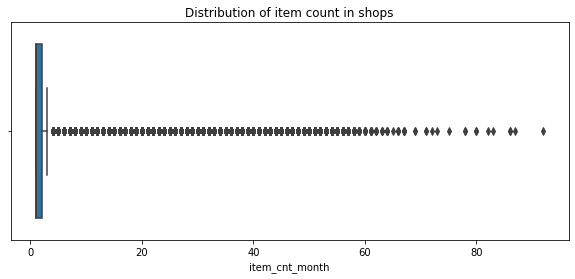

sales_train_montly_df has shape  (10685502, 8)


In [11]:
def prepare_sales_monthly(sales):    
    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(['date_block_num', 'shop_id', 'item_id'],as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={"item_cnt_day": "item_cnt_month"})

    plt.figure(figsize = (10,4))
    sns.boxplot(gb['item_cnt_month'])
    plt.title("Distribution of item count in shops")
    plt.show()
    
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['date_block_num', 'item_id'],as_index=False).agg({'item_price':'mean'})
    gb = gb.rename(columns={"item_price": "item_price_avg"})
    all_data = pd.merge(all_data, gb, how='left', on=['date_block_num', 'item_id']).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={"item_cnt_day": "target_shop"})
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb = gb.rename(columns={"item_cnt_day": "target_item"})
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
    
    #find when an item was first sold
    first_items_sales = all_data.groupby('item_id')['date_block_num'].min()
    all_data['when_first_sold'] = all_data['item_id'].map(first_items_sales)
    all_data['when_first_sold'] = all_data['date_block_num'] - all_data['when_first_sold']

    print('sales_train_montly_df has shape ', all_data.shape)
    return all_data

aggregated_sales = prepare_sales_monthly(sales)

In [12]:
aggregated_sales.tail(10)

shop_id  item_id  date_block_num  item_cnt_month  item_price_avg  \
10685492       21     7610              33             0.0          2890.0   
10685493       21     7612              33             0.0           250.0   
10685494       21     7615              33             0.0           250.0   
10685495       21     7627              33             0.0           349.0   
10685496       21     7628              33             0.0           250.0   
10685497       21     7635              33             0.0          2100.0   
10685498       21     7638              33             0.0          1890.0   
10685499       21     7640              33             0.0          4040.0   
10685500       21     7632              33             0.0          2310.0   
10685501       21     7440              33             0.0           299.0   

          target_shop  target_item  when_first_sold  
10685492       1678.0          1.0                0  
10685493       1678.0          1.0                7  
10685494       1678.0          1.0               10  
10685495       1678.0          1.0               10  
10685496       1678.0          1.0               10  
10685497       1678.0          1.0                0  
10685498       1678.0          1.0                9  
10685499       1678.0          1.0                0  
10685500       1678.0          1.0               10  
10685501       1678.0          1.0                7

<Figure size 720x288 with 0 Axes>

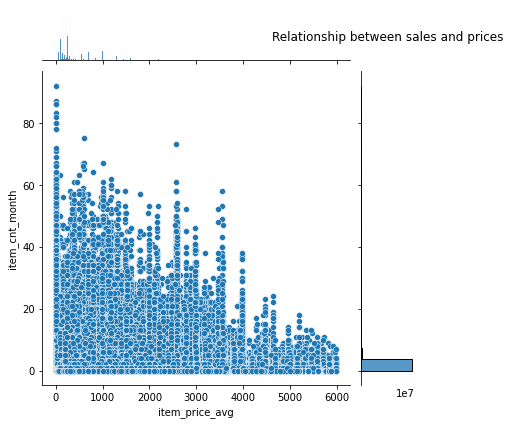

In [13]:
def show_sale_price_split():
    plt.figure(figsize = (10,4))
    sns.jointplot(x = "item_price_avg", y = "item_cnt_month", data = aggregated_sales);
    plt.title("Relationship between sales and prices", y=1.08)
show_sale_price_split()    

We can see that the bulk of data is sold less than 10 times and this explains the value in using clipping at the end. Most of items are also priced low.
Let's see how prices change over time.

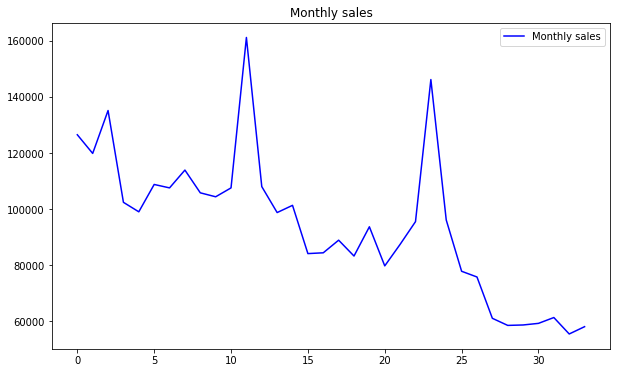

In [14]:
def show_monthly_sale():
    df_grouped_by_date = aggregated_sales[["date_block_num", "item_cnt_month"]].groupby("date_block_num").sum()

    plt.figure(figsize = (10, 6))
    plt.plot(df_grouped_by_date, color = "blue", label = "Monthly sales")
    plt.title("Monthly sales")
    plt.legend();
    
show_monthly_sale()

We can clearly see that the sales are going down over time with peaks around

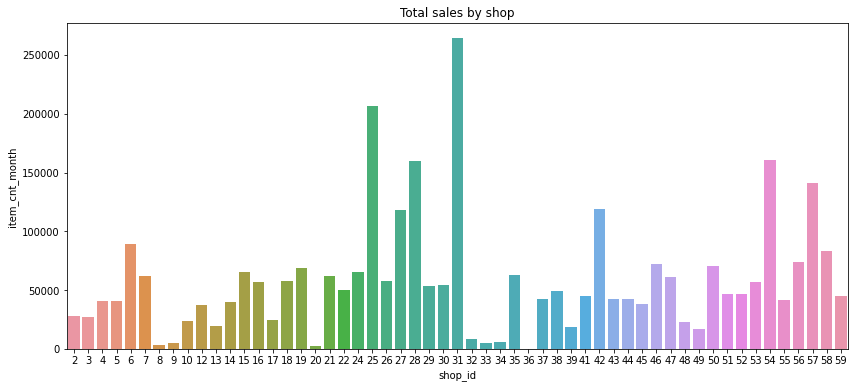

In [15]:
def show():
    df_grouped_by_shop = aggregated_sales[["item_cnt_month", "shop_id"]].groupby("shop_id").sum()
    df_grouped_by_shop.reset_index(level=0, inplace=True)
    plt.figure(figsize=(14,6))
    plt.title("Total sales by shop")
    sns.barplot(x = "shop_id", y = "item_cnt_month", data = df_grouped_by_shop);
show()    

## Item Category

In [16]:
items_category = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
items_category.head(10)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
5      Аксессуары - PSVita                 5
6    Аксессуары - XBOX 360                 6
7    Аксессуары - XBOX ONE                 7
8           Билеты (Цифра)                 8
9          Доставка товара                 9

From the Item Category we can tell that the items are games related.  
If we look at a category like *Аксессуары - PS3* we can tell that it contains accessories for *PS3*. What we decided to do is to split the categories and use the left part as a new category type called main (imagine this as an aggregated category).  
We will also extract information about whether or not the category is digital (*Цифра*) and if it is PS, PC or Xbox related

In [17]:
def correct_item_category_name(df):
    df.loc[df['item_category_name'] == 'Билеты (Цифра)','item_category_name'] = 'Билеты - Цифра'
    df.loc[df['item_category_name'] == 'Доставка товара','item_category_name'] = 'Доставка товара - service'
    df.loc[df['item_category_name'] == 'Карты оплаты (Кино, Музыка, Игры)',
           'item_category_name'] = 'Карты оплаты - Кино, Музыка, Игры'
    df.loc[df['item_category_name'] == 'Служебные','item_category_name'] = 'Служебные - none'
    df.loc[df['item_category_name'] == 'Чистые носители (шпиль)','item_category_name'] = 'Чистые носители - шпиль'
    df.loc[df['item_category_name'] == 'Чистые носители (штучные)','item_category_name'] = 'Чистые носители - штучные'
    df.loc[df['item_category_name'] == 'Элементы питания','item_category_name'] = 'Элементы питания - none'

    return df


def extract_main_category(df):
    df['item_category_main'] = df['item_category_name'].str.split(' - ').str[0]

    le = preprocessing.OrdinalEncoder(dtype=np.int32)
    df['item_category_main'] = le.fit_transform(df[['item_category_main']])

    return df


def extract_whether_digital(df):
    df['is_category_digital'] = 0
    df.loc[df['item_category_name'].str.contains('Цифра'),'is_category_digital'] = 1

    return df


def extract_ps_related(df):
    df['is_category_ps_related'] = 0
    df.loc[df['item_category_name'].str.contains('PS', case=False), 'is_category_ps_related'] = 1    
    
    df['is_category_pc_related'] = 0
    df.loc[df['item_category_name'].str.contains('PC', case=False), 'is_category_pc_related'] = 1    
    
    df['is_category_xbox_related'] = 0
    df.loc[df['item_category_name'].str.contains('XBOX', case=False), 'is_category_xbox_related'] = 1

    return df


def fix_item_category(df):
    df = correct_item_category_name(df)
    df = extract_main_category(df)
    df = extract_whether_digital(df)
    df = extract_ps_related(df)
    df.drop(columns = ['item_category_name'], inplace = True)

    return df

items_category_extra = fix_item_category(items_category)
items_category_extra.head(10)

item_category_id  item_category_main  is_category_digital  \
0                 0                   0                    0   
1                 1                   1                    0   
2                 2                   1                    0   
3                 3                   1                    0   
4                 4                   1                    0   
5                 5                   1                    0   
6                 6                   1                    0   
7                 7                   1                    0   
8                 8                   2                    1   
9                 9                   3                    0   

   is_category_ps_related  is_category_pc_related  is_category_xbox_related  
0                       0                       1                         0  
1                       1                       0                         0  
2                       1                       0                         0  
3                       1                       0                         0  
4                       1                       0                         0  
5                       1                       0                         0  
6                       0                       0                         1  
7                       0                       0                         1  
8                       0                       0                         0  
9                       0                       0                         0

## Items

In [18]:
items = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
items.drop(columns=['item_name'], inplace=True)
items.head(10)

item_id  item_category_id
0        0                40
1        1                76
2        2                40
3        3                40
4        4                40
5        5                40
6        6                40
7        7                40
8        8                40
9        9                40

Item is an interesting one. I have a feeling that we could use some sort of NLP to extract information from a title. I did quite a bit of analysis trying to understad why we have so much error in the test set. It looks like we have, for example, few new games that were not sold in the previous months. It is difficult for this model to predict something new but by using the text information we could find more complex relationships. I did not continue on this road for lack of time. My goal is not to achieve a perfect score but to learn new how to take part in a competition and wondering into NLP would have distracted me from my learning goals. That's why I decided to just drop the item_name

## Create DataFrame for training
Let's create a final dataframe that combines all the different sources

In [19]:
def create_df():
    merged_df = aggregated_sales.merge(shops, on = 'shop_id', how = 'left')
    items_to_merge = items.merge(items_category_extra, on = 'item_category_id')
    merged_df = merged_df.merge(items_to_merge, on = 'item_id', how = 'left')
    
    return merged_df

all_data = create_df()

Add total sales by category

In [20]:
def add_targets(merged_df):
    gb = merged_df.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_month':'sum'})
    gb = gb.rename(columns={"item_cnt_month": "target_category"})
    all_data = pd.merge(merged_df, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
    
    gb = merged_df.groupby(['item_category_main', 'date_block_num'],as_index=False).agg({'item_cnt_month':'sum'})
    gb = gb.rename(columns={"item_cnt_month": "target_category_main"})
    all_data = pd.merge(all_data, gb, how='left', on=['item_category_main', 'date_block_num']).fillna(0)

    gb = merged_df.groupby(['shop_id','item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_month':'sum'})
    gb = gb.rename(columns={"item_cnt_month": "target_shop_category"})
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id','item_category_id', 'date_block_num']).fillna(0)
    
    return all_data

all_data = add_targets(all_data)

In [21]:
all_data.head(10)

shop_id  item_id  date_block_num  item_cnt_month  item_price_avg  \
0       59    22154               0             1.0      999.000000   
1       59     2552               0             0.0      899.000000   
2       59     2554               0             0.0     1709.050000   
3       59     2555               0             0.0     1098.850000   
4       59     2564               0             0.0      327.600000   
5       59     2565               0             0.0      549.000000   
6       59     2572               0             0.0      284.333333   
7       59     2573               0             0.0      299.000000   
8       59     2574               0             2.0      392.986538   
9       59     2593               0             0.0      254.200000   

   target_shop  target_item  when_first_sold  shop_type_1  shop_type_2  \
0       1959.0         18.0                0            1            1   
1       1959.0          1.0                0            1            1   
2       1959.0          1.0                0            1            1   
3       1959.0          2.0                0            1            1   
4       1959.0          5.0                0            1            1   
5       1959.0          2.0                0            1            1   
6       1959.0         12.0                0            1            1   
7       1959.0         16.0                0            1            1   
8       1959.0        119.0                0            1            1   
9       1959.0          5.0                0            1            1   

   shop_city_type  shop_city  item_category_id  item_category_main  \
0               0         30                37                  10   
1               0         30                58                  12   
2               0         30                58                  12   
3               0         30                56                  12   
4               0         30                59                  12   
5               0         30                56                  12   
6               0         30                55                  12   
7               0         30                55                  12   
8               0         30                55                  12   
9               0         30                55                  12   

   is_category_digital  is_category_ps_related  is_category_pc_related  \
0                    0                       0                       0   
1                    0                       0                       0   
2                    0                       0                       0   
3                    0                       0                       0   
4                    0                       0                       0   
5                    0                       0                       0   
6                    0                       0                       0   
7                    0                       0                       0   
8                    0                       0                       0   
9                    0                       0                       0   

   is_category_xbox_related  target_category  target_category_main  \
0                         0           6074.0               41389.0   
1                         0            292.0               15426.0   
2                         0            292.0               15426.0   
3                         0            268.0               15426.0   
4                         0            707.0               15426.0   
5                         0            268.0               15426.0   
6                         0          12538.0               15426.0   
7                         0          12538.0               15426.0   
8                         0          12538.0               15426.0   
9                         0          12538.0               15426.0   

   target_shop_category  
0                  60.0

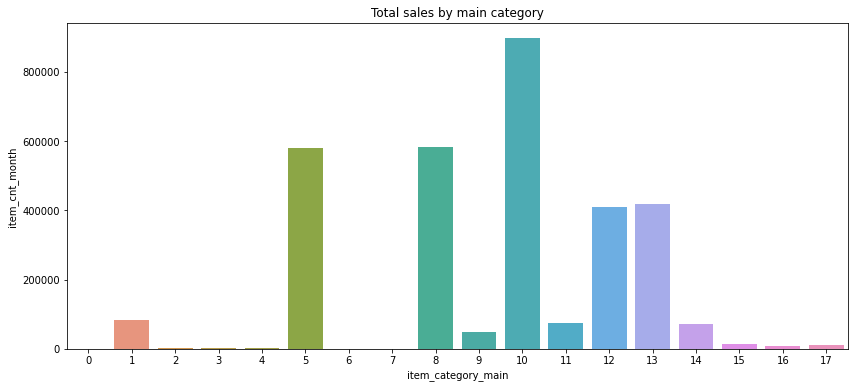

In [22]:
def show():
    df_grouped_by_category = all_data[["item_cnt_month", "item_category_main"]].groupby("item_category_main").sum()
    df_grouped_by_category.reset_index(level=0, inplace=True)
    plt.figure(figsize=(14,6))
    plt.title("Total sales by main category")
    sns.barplot(x = "item_category_main", y = "item_cnt_month", data = df_grouped_by_category);
show()  

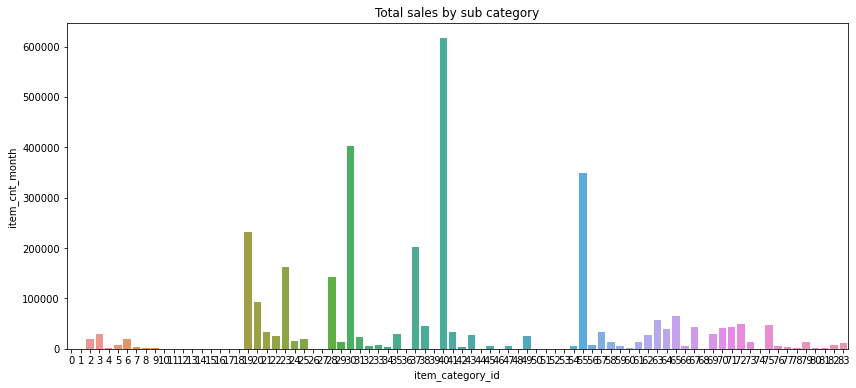

In [23]:
def show():
    df_grouped_by_category = all_data[["item_cnt_month", "item_category_id"]].groupby("item_category_id").sum()
    df_grouped_by_category.reset_index(level=0, inplace=True)
    plt.figure(figsize=(14,6))
    plt.title("Total sales by sub category")
    sns.barplot(x = "item_category_id", y = "item_cnt_month", data = df_grouped_by_category);
show()  

Main category 10 is blue ray and it contains the most number of items. This can cause some noise in the predictions since a lot of blue rays change from month to month

When training in Kaggle the previous process leaves a lot of data in memory. I will clean the leftovers before moving to the next part of the task

In [24]:
del aggregated_sales
del items_category_extra
del items_category
del sales
del shops
del items
all_data = downcast_dtypes(all_data)
gc.collect()

43937

If I add the lag now I sometimes run out of memory in Kaggle.  
The only way to fix this is to save the dataframe and restart the kernel from here

In [ ]:
#pickle.dump(all_data, open(f"all_data_train.pickle.dat", "wb"))

In [ ]:
# infile = open(f"all_data_train.pickle.dat", "rb")
# all_data = pickle.load(infile)
# infile.close()

# Add lags

We cannot use ```'item_price_avg','item_cnt_month', 'target_shop','target_item', 'target_shop_category','target_category','target_category_main'``` for the current month but we can use the information from the previous months. Let's create lag values as explained in the training. I've experimented with different shift ranges and I finally settled down for this ```[1, 2, 3, 4, 5, 12]```

In [25]:
def add_lag(all_data):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    # List of columns that we will use to create lags
    cols_to_rename = ['item_price_avg','item_cnt_month', 'target_shop','target_item', 'target_shop_category','target_category','target_category_main']

    shift_range = [1, 2, 3, 4, 5, 12]

    for month_shift in shift_range: #tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

        del train_shift
        gc.collect();
    return all_data
    
all_data = add_lag(all_data)

I decided not to use old data from year 2013. This will keep the lag information consistent(every item will have a lag_12 feature)

In [26]:
all_data = all_data[all_data['date_block_num'] >= 12] 
all_data = downcast_dtypes(all_data)

In [27]:
all_data.head(10)

shop_id  item_id  date_block_num  item_cnt_month  item_price_avg  \
4412829       54    10297              12             4.0         749.000   
4412830       54    10296              12             3.0        1570.000   
4412831       54    10298              12            14.0         394.500   
4412832       54    10300              12             3.0         699.000   
4412833       54    10284              12             1.0         299.000   
4412834       54    10292              12             9.0          98.375   
4412835       54    10109              12             2.0         144.375   
4412836       54    10107              12             1.0         299.000   
4412837       54    10121              12             1.0         149.000   
4412838       54    10143              12             1.0        2148.000   

         target_shop  target_item  when_first_sold  shop_type_1  shop_type_2  \
4412829       7200.0         23.0                2            1            1   
4412830       7200.0         17.0                1            1            1   
4412831       7200.0        178.0                3            1            1   
4412832       7200.0         27.0                3            1            1   
4412833       7200.0          3.0               10            1            1   
4412834       7200.0         93.0               11            1            1   
4412835       7200.0         17.0               11            1            1   
4412836       7200.0         26.0               12            1            1   
4412837       7200.0          1.0               12            1            1   
4412838       7200.0         12.0                2            1            1   

         shop_city_type  shop_city  item_category_id  item_category_main  \
4412829               0         26                37                  10   
4412830               0         26                38                  10   
4412831               0         26                40                  10   
4412832               0         26                37                  10   
4412833               0         26                57                  12   
4412834               0         26                40                  10   
4412835               0         26                40                  10   
4412836               0         26                37                  10   
4412837               0         26                37                  10   
4412838               0         26                55                  12   

         is_category_digital  is_category_ps_related  is_category_pc_related  \
4412829                    0                       0                       0   
4412830                    0                       0                       0   
4412831                    0                       0                       0   
4412832                    0                       0                       0   
4412833                    0                       0                       0   
4412834                    0                       0                       0   
4412835                    0                       0                       0   
4412836                    0                       0                       0   
4412837                    0                       0                       0   
4412838                    0                       0                       0   

         is_category_xbox_related  target_category  target_category_main  \
4412829                         0           7544.0               31936.0   
4412830                         0           1417.0               31936.0   
4412831                         0          21728.0               31936.0   
4412832                         0           7544.0               31936.0   
4412833                         0            987.0               12016.0   
4412834                         0          21728.0               31936.0   
4412835                       

## Add information about days in the month

The more days are in a month the more items are sold. It might useful to add this information to the dataframe

In [28]:
def calculate_number_of_particular_days(day_of_week):
    """
    Function that calculates how many particular days were in each months of 2013-2015
                    (like how many mondays were in 02.2014)
    :arg day_of_week (int) number of weekday (0 - Monday, 6 - Sunday)
    :return: day_of_week_series (pandas series) index - month_number, value - number of particular day
    """

    def checkio(from_date, to_date, day_of_week):
        return len([1 for d in range((to_date - from_date).days + 1)
                    if (from_date + timedelta(d)).weekday() in [day_of_week]])

    month_number = []
    number_of_weekend_days = []

    counter = 0
    for year in [2013, 2014, 2015]:
        for month in range(1, 13):
            start_m, end_m = monthrange(year, month)
            weekend_days_in_month = checkio(date(year, month, 1), date(year, month, end_m), day_of_week)
            month_number.append(counter)
            number_of_weekend_days.append(weekend_days_in_month)
            counter += 1
    day_of_week_series = pd.Series(index=month_number, data=number_of_weekend_days)

    return day_of_week_series

def add_days_stat(df):
    df['number_of_saturdays'] = df['date_block_num'].map(calculate_number_of_particular_days(5)).astype(np.int8)
    df['number_of_sundays'] = df['date_block_num'].map(calculate_number_of_particular_days(6)).astype(np.int8)
    df['number_of_mondays'] = df['date_block_num'].map(calculate_number_of_particular_days(0)).astype(np.int8)
    df['number_of_days_in_month'] = df['date_block_num'].map(
        pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])).astype(np.int8)

    return df

all_data = add_days_stat(all_data)

This has been my last successful change. I added the number of holidays in a month to account for the peaks in sales during holidays.

In [29]:
all_data['holidays_in_month'] = all_data['date_block_num'] % 12
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}
all_data['holidays_in_month'] = all_data['holidays_in_month'].map(holiday_dict)

In [30]:
all_data.head(10)

shop_id  item_id  date_block_num  item_cnt_month  item_price_avg  \
4412829       54    10297              12             4.0         749.000   
4412830       54    10296              12             3.0        1570.000   
4412831       54    10298              12            14.0         394.500   
4412832       54    10300              12             3.0         699.000   
4412833       54    10284              12             1.0         299.000   
4412834       54    10292              12             9.0          98.375   
4412835       54    10109              12             2.0         144.375   
4412836       54    10107              12             1.0         299.000   
4412837       54    10121              12             1.0         149.000   
4412838       54    10143              12             1.0        2148.000   

         target_shop  target_item  when_first_sold  shop_type_1  shop_type_2  \
4412829       7200.0         23.0                2            1            1   
4412830       7200.0         17.0                1            1            1   
4412831       7200.0        178.0                3            1            1   
4412832       7200.0         27.0                3            1            1   
4412833       7200.0          3.0               10            1            1   
4412834       7200.0         93.0               11            1            1   
4412835       7200.0         17.0               11            1            1   
4412836       7200.0         26.0               12            1            1   
4412837       7200.0          1.0               12            1            1   
4412838       7200.0         12.0                2            1            1   

         shop_city_type  shop_city  item_category_id  item_category_main  \
4412829               0         26                37                  10   
4412830               0         26                38                  10   
4412831               0         26                40                  10   
4412832               0         26                37                  10   
4412833               0         26                57                  12   
4412834               0         26                40                  10   
4412835               0         26                40                  10   
4412836               0         26                37                  10   
4412837               0         26                37                  10   
4412838               0         26                55                  12   

         is_category_digital  is_category_ps_related  is_category_pc_related  \
4412829                    0                       0                       0   
4412830                    0                       0                       0   
4412831                    0                       0                       0   
4412832                    0                       0                       0   
4412833                    0                       0                       0   
4412834                    0                       0                       0   
4412835                    0                       0                       0   
4412836                    0                       0                       0   
4412837                    0                       0                       0   
4412838                    0                       0                       0   

         is_category_xbox_related  target_category  target_category_main  \
4412829                         0           7544.0               31936.0   
4412830                         0           1417.0               31936.0   
4412831                         0          21728.0               31936.0   
4412832                         0           7544.0               31936.0   
4412833                         0            987.0               12016.0   
4412834                         0          21728.0               31936.0   
4412835                       

In [31]:
pickle.dump(all_data, open(f"all_data_train_with_lag.pickle.dat", "wb"))

We tried to implement target encoding as well but this did actually decrease the score for this model.  
This might be caused by the interaction with other features.  
I had a look at the following in the test dataset  
```python
corr = np.corrcoef(test['item_cnt_month_lag_1'].values, test['item_target_enc'])[0][1]
print(corr)
corr = np.corrcoef(test['item_cnt_month'].values, test['item_target_enc'])[0][1]
print(corr)
corr = np.corrcoef(test['item_cnt_month'].values, test['item_cnt_month_lag_1'])[0][1]
print(corr)
```
and found high correlation:
```
0.6048544847510883
0.6702593454945617
0.8426105262541285
```

Target encoding will not be included in the final model.

In [ ]:
from sklearn.model_selection import KFold
def target_encoding():
    all_data['item_target_enc'] = 0.3343

    kf = KFold(n_splits=5, shuffle=False)
    for train_index, test_index in kf.split(all_data):
        x_tr, x_val = all_data.iloc[train_index], all_data.iloc[test_index]
        item_enc = x_tr.groupby('item_id').item_cnt_month.mean()
        all_data['item_target_enc'].iloc[test_index] = x_val['item_id'].map(item_enc)

    # Fill NaNs
    all_data['item_target_enc'].fillna(0.3343, inplace=True)
    encoded_feature = all_data['item_target_enc'].values
    # You will need to compute correlation like that
    corr = np.corrcoef(all_data['item_cnt_month'].values, encoded_feature)[0][1]
    print(corr)
    
# target_encoding()

# Train a Model

Now that we have the data we want to train a model. We use XGBoost for the prediction.
We will first divide the dataset in train and validation and find the best values to avoid overfitting.
We then train the final model in the combination of train and validation and use that to predict test.

We started training using the default values from https://github.com/kaz-Anova/StackNet/blob/master/parameters/PARAMETERS.MD
```python
booster:gbtree num_round:1000 
eta:0.005 max_leaves:0 gamma:1. max_depth:5 min_child_weight:1.0 subsample:0.9 colsample_bytree:0.7 
colsample_bylevel:1.0 lambda:1.0 alpha:1.0
```

We have quite a bit of features so we started increasing the max_depth to 10.  
This improved the validation 
```
rmse from 0.98331 to 0.96434
```  
We then started increasing the eta until we reached overfitting  
```
eta 0.1  gave use validation_0-rmse:0.69856	validation_1-rmse:0.78053
```  
and finally reduced down to a comfortable level  
```
eta 0.05 validation_0-rmse:0.72841	validation_1-rmse:0.77370
```  
The last change was using less features while increasing the dataset used:  
```python
colsample_bytree=0.60 from 0.7 
subsample=0.95 from 0.9 
```
This gave us the final result of
```
validation_0-rmse:0.73202	validation_1-rmse:0.78107
```

In [ ]:
# infile = open(f"all_data_train_with_lag.pickle.dat", "rb")
# all_data = pickle.load(infile)
# infile.close()

In [32]:
target_col = ['item_cnt_month']
columns_to_drop = ['item_price_avg','item_cnt_month', 'target_shop','target_item', 'target_shop_category','target_category','target_category_main']
features_col = list(all_data.columns.difference(columns_to_drop)) 

I added the code outcome of the training:
```
[22:31:10] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[22:31:11] WARNING: ../src/learner.cc:516: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.25853	validation_1-rmse:1.14099
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.22460	validation_1-rmse:1.11356
[2]	validation_0-rmse:1.19269	validation_1-rmse:1.09012
[3]	validation_0-rmse:1.16228	validation_1-rmse:1.06741
[4]	validation_0-rmse:1.13689	validation_1-rmse:1.04680
[5]	validation_0-rmse:1.11090	validation_1-rmse:1.02778
[6]	validation_0-rmse:1.08882	validation_1-rmse:1.01234
[7]	validation_0-rmse:1.06565	validation_1-rmse:0.99653
[8]	validation_0-rmse:1.04457	validation_1-rmse:0.98189
[9]	validation_0-rmse:1.02636	validation_1-rmse:0.96684
[10]	validation_0-rmse:1.00752	validation_1-rmse:0.95454
[11]	validation_0-rmse:0.98960	validation_1-rmse:0.94244
[12]	validation_0-rmse:0.97280	validation_1-rmse:0.93191
[13]	validation_0-rmse:0.95730	validation_1-rmse:0.92139
[14]	validation_0-rmse:0.94337	validation_1-rmse:0.91272
[15]	validation_0-rmse:0.93072	validation_1-rmse:0.90263
[16]	validation_0-rmse:0.91853	validation_1-rmse:0.89321
[17]	validation_0-rmse:0.90737	validation_1-rmse:0.88524
[18]	validation_0-rmse:0.89686	validation_1-rmse:0.87813
[19]	validation_0-rmse:0.88693	validation_1-rmse:0.87336
[20]	validation_0-rmse:0.87831	validation_1-rmse:0.86652
[21]	validation_0-rmse:0.86933	validation_1-rmse:0.86113
[22]	validation_0-rmse:0.86106	validation_1-rmse:0.85611
[23]	validation_0-rmse:0.85339	validation_1-rmse:0.85117
[24]	validation_0-rmse:0.84602	validation_1-rmse:0.84695
[25]	validation_0-rmse:0.83923	validation_1-rmse:0.84331
[26]	validation_0-rmse:0.83253	validation_1-rmse:0.83986
[27]	validation_0-rmse:0.82654	validation_1-rmse:0.83668
[28]	validation_0-rmse:0.82110	validation_1-rmse:0.83256
[29]	validation_0-rmse:0.81526	validation_1-rmse:0.82975
[30]	validation_0-rmse:0.81114	validation_1-rmse:0.82652
[31]	validation_0-rmse:0.80712	validation_1-rmse:0.82380
[32]	validation_0-rmse:0.80256	validation_1-rmse:0.82158
[33]	validation_0-rmse:0.79805	validation_1-rmse:0.81908
[34]	validation_0-rmse:0.79350	validation_1-rmse:0.81744
[35]	validation_0-rmse:0.78969	validation_1-rmse:0.81520
[36]	validation_0-rmse:0.78594	validation_1-rmse:0.81311
[37]	validation_0-rmse:0.78232	validation_1-rmse:0.81147
[38]	validation_0-rmse:0.77911	validation_1-rmse:0.81032
[39]	validation_0-rmse:0.77616	validation_1-rmse:0.80886
[40]	validation_0-rmse:0.77315	validation_1-rmse:0.80762
[41]	validation_0-rmse:0.77010	validation_1-rmse:0.80627
[42]	validation_0-rmse:0.76770	validation_1-rmse:0.80476
[43]	validation_0-rmse:0.76447	validation_1-rmse:0.80392
[44]	validation_0-rmse:0.76256	validation_1-rmse:0.80272
[45]	validation_0-rmse:0.76018	validation_1-rmse:0.80169
[46]	validation_0-rmse:0.75790	validation_1-rmse:0.80118
[47]	validation_0-rmse:0.75533	validation_1-rmse:0.80025
[48]	validation_0-rmse:0.75326	validation_1-rmse:0.79923
[49]	validation_0-rmse:0.75197	validation_1-rmse:0.79874
[50]	validation_0-rmse:0.74974	validation_1-rmse:0.79745
[51]	validation_0-rmse:0.74825	validation_1-rmse:0.79669
[52]	validation_0-rmse:0.74615	validation_1-rmse:0.79648
[53]	validation_0-rmse:0.74451	validation_1-rmse:0.79602
[54]	validation_0-rmse:0.74235	validation_1-rmse:0.79555
[55]	validation_0-rmse:0.74068	validation_1-rmse:0.79528
[56]	validation_0-rmse:0.73929	validation_1-rmse:0.79484
[57]	validation_0-rmse:0.73743	validation_1-rmse:0.79459
[58]	validation_0-rmse:0.73584	validation_1-rmse:0.79400
[59]	validation_0-rmse:0.73417	validation_1-rmse:0.79314
[60]	validation_0-rmse:0.73304	validation_1-rmse:0.79260
[61]	validation_0-rmse:0.73138	validation_1-rmse:0.79227
[62]	validation_0-rmse:0.72974	validation_1-rmse:0.79228
[63]	validation_0-rmse:0.72847	validation_1-rmse:0.79199
[64]	validation_0-rmse:0.72705	validation_1-rmse:0.79189
[65]	validation_0-rmse:0.72582	validation_1-rmse:0.79172
[66]	validation_0-rmse:0.72457	validation_1-rmse:0.79128
[67]	validation_0-rmse:0.72316	validation_1-rmse:0.79100
[68]	validation_0-rmse:0.72197	validation_1-rmse:0.79082
[69]	validation_0-rmse:0.72055	validation_1-rmse:0.79019
[70]	validation_0-rmse:0.71945	validation_1-rmse:0.78959
[71]	validation_0-rmse:0.71854	validation_1-rmse:0.78951
[72]	validation_0-rmse:0.71744	validation_1-rmse:0.78932
[73]	validation_0-rmse:0.71637	validation_1-rmse:0.78922
[74]	validation_0-rmse:0.71543	validation_1-rmse:0.78883
[75]	validation_0-rmse:0.71454	validation_1-rmse:0.78848
[76]	validation_0-rmse:0.71345	validation_1-rmse:0.78830
[77]	validation_0-rmse:0.71244	validation_1-rmse:0.78769
[78]	validation_0-rmse:0.71136	validation_1-rmse:0.78766
[79]	validation_0-rmse:0.71064	validation_1-rmse:0.78740
[80]	validation_0-rmse:0.70966	validation_1-rmse:0.78717
[81]	validation_0-rmse:0.70886	validation_1-rmse:0.78663
[82]	validation_0-rmse:0.70782	validation_1-rmse:0.78660
[83]	validation_0-rmse:0.70710	validation_1-rmse:0.78657
[84]	validation_0-rmse:0.70637	validation_1-rmse:0.78644
[85]	validation_0-rmse:0.70571	validation_1-rmse:0.78644
[86]	validation_0-rmse:0.70507	validation_1-rmse:0.78608
[87]	validation_0-rmse:0.70439	validation_1-rmse:0.78614
[88]	validation_0-rmse:0.70377	validation_1-rmse:0.78611
[89]	validation_0-rmse:0.70312	validation_1-rmse:0.78592
[90]	validation_0-rmse:0.70260	validation_1-rmse:0.78592
[91]	validation_0-rmse:0.70182	validation_1-rmse:0.78586
[92]	validation_0-rmse:0.70103	validation_1-rmse:0.78568
[93]	validation_0-rmse:0.70035	validation_1-rmse:0.78573
[94]	validation_0-rmse:0.69953	validation_1-rmse:0.78560
[95]	validation_0-rmse:0.69878	validation_1-rmse:0.78554
[96]	validation_0-rmse:0.69814	validation_1-rmse:0.78521
[97]	validation_0-rmse:0.69758	validation_1-rmse:0.78506
[98]	validation_0-rmse:0.69691	validation_1-rmse:0.78481
[99]	validation_0-rmse:0.69632	validation_1-rmse:0.78466
took  70.1292793750763
```

In [ ]:
def validate():
    train = all_data[(all_data["date_block_num"] < 33)]
    val = all_data[(all_data["date_block_num"] == 33)]

    X_train = train[features_col]
    X_val = val[features_col]

    Y_train = train[target_col]
    Y_val = val[target_col]

    xgb_reg_1 = xgb.XGBRegressor(
        tree_method= 'gpu_hist',
        n_gpus= 1,
        num_round=1000, #Number of estimators to build (int) . This is important.
        eta=0.05,#	Penalty applied to each estimator. Needs to be between 0 and 1 (double). This is important.
        max_leaves=0,
        gamma=1,
        max_depth=10, #Maximum depth of the tree (int). This is important.
        min_child_weight=1.0,
        subsample=0.95,#Proportion of observations to consider (double). This is important.
        colsample_bytree=0.60,#Proportion of columns (features) to consider in each Tree (double) This is important.
        colsample_bylevel=1.0,#Proportion of columns (features) to consider in each level (double).
        reg_lambda=1.0,
        alpha=1.0,
        seed=42)

    ts = time.time()

    xgb_reg_1.fit(
        X_train,
        Y_train,
        eval_metric="rmse",
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        verbose=True,
        early_stopping_rounds=20)

    print("took ", time.time() - ts)
#uncomment if you want to train again. You do need a gpu or to remove the gpu related code.
#validate()
# pickle.dump(xgb_reg_1, open("model.pickle.dat", "wb"))

We had a look at the interaction between validation prediction and label:  
![Label Vs Prediction](val_pred.png)  
Most of the predictions are around very low numbers (as expected) confirming the validity of clipping.  
There is a little bit of scew in the direction of the label but it is not clear the impact of this on the final score.

In [109]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    plt.figure(figsize = (10,4))
    sns.jointplot(y="Label", x="Prediction", data=performance_df)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

#I commented this out since it takes a decent amount of time
#Y_pred = xgb_reg_1.predict(X_val)
#model_performance_sc_plot(Y_pred, Y_val.item_cnt_month.values, 'Validation')

Train the final model after having identified the right hyperparameters.
I am adding here the output from the training
```
[21:25:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.25378
[1]	validation_0-rmse:1.22419
[2]	validation_0-rmse:1.19428
[3]	validation_0-rmse:1.15995
[4]	validation_0-rmse:1.13284
[5]	validation_0-rmse:1.11007
[6]	validation_0-rmse:1.08825
[7]	validation_0-rmse:1.06892
[8]	validation_0-rmse:1.05145
[9]	validation_0-rmse:1.03561
[10]	validation_0-rmse:1.01988
[11]	validation_0-rmse:1.00475
[12]	validation_0-rmse:0.99062
[13]	validation_0-rmse:0.98056
[14]	validation_0-rmse:0.96684
[15]	validation_0-rmse:0.95228
[16]	validation_0-rmse:0.94104
[17]	validation_0-rmse:0.93026
[18]	validation_0-rmse:0.92045
[19]	validation_0-rmse:0.91264
[20]	validation_0-rmse:0.90414
[21]	validation_0-rmse:0.89502
[22]	validation_0-rmse:0.88722
[23]	validation_0-rmse:0.87960
[24]	validation_0-rmse:0.87403
[25]	validation_0-rmse:0.86789
[26]	validation_0-rmse:0.86202
[27]	validation_0-rmse:0.85685
[28]	validation_0-rmse:0.85168
[29]	validation_0-rmse:0.84642
[30]	validation_0-rmse:0.84213
[31]	validation_0-rmse:0.83800
[32]	validation_0-rmse:0.83426
[33]	validation_0-rmse:0.83020
[34]	validation_0-rmse:0.82668
[35]	validation_0-rmse:0.82298
[36]	validation_0-rmse:0.81965
[37]	validation_0-rmse:0.81639
[38]	validation_0-rmse:0.81361
[39]	validation_0-rmse:0.81091
[40]	validation_0-rmse:0.80831
[41]	validation_0-rmse:0.80647
[42]	validation_0-rmse:0.80411
[43]	validation_0-rmse:0.80158
[44]	validation_0-rmse:0.79938
[45]	validation_0-rmse:0.79753
[46]	validation_0-rmse:0.79549
[47]	validation_0-rmse:0.79418
[48]	validation_0-rmse:0.79218
[49]	validation_0-rmse:0.79084
[50]	validation_0-rmse:0.78904
[51]	validation_0-rmse:0.78770
[52]	validation_0-rmse:0.78582
[53]	validation_0-rmse:0.78396
[54]	validation_0-rmse:0.78242
[55]	validation_0-rmse:0.78026
[56]	validation_0-rmse:0.77891
[57]	validation_0-rmse:0.77755
[58]	validation_0-rmse:0.77582
[59]	validation_0-rmse:0.77413
[60]	validation_0-rmse:0.77245
[61]	validation_0-rmse:0.77131
[62]	validation_0-rmse:0.76983
[63]	validation_0-rmse:0.76840
[64]	validation_0-rmse:0.76718
[65]	validation_0-rmse:0.76605
[66]	validation_0-rmse:0.76474
[67]	validation_0-rmse:0.76363
[68]	validation_0-rmse:0.76256
[69]	validation_0-rmse:0.76180
[70]	validation_0-rmse:0.76079
[71]	validation_0-rmse:0.75955
[72]	validation_0-rmse:0.75856
[73]	validation_0-rmse:0.75762
[74]	validation_0-rmse:0.75693
[75]	validation_0-rmse:0.75602
[76]	validation_0-rmse:0.75493
[77]	validation_0-rmse:0.75406
[78]	validation_0-rmse:0.75328
[79]	validation_0-rmse:0.75250
[80]	validation_0-rmse:0.75169
[81]	validation_0-rmse:0.75080
[82]	validation_0-rmse:0.75019
[83]	validation_0-rmse:0.74942
[84]	validation_0-rmse:0.74869
[85]	validation_0-rmse:0.74809
[86]	validation_0-rmse:0.74752
[87]	validation_0-rmse:0.74674
[88]	validation_0-rmse:0.74573
[89]	validation_0-rmse:0.74470
[90]	validation_0-rmse:0.74396
[91]	validation_0-rmse:0.74294
[92]	validation_0-rmse:0.74248
[93]	validation_0-rmse:0.74174
[94]	validation_0-rmse:0.74102
[95]	validation_0-rmse:0.74063
[96]	validation_0-rmse:0.73974
[97]	validation_0-rmse:0.73922
[98]	validation_0-rmse:0.73856
[99]	validation_0-rmse:0.73809
took  3154.453556060791
```

In [ ]:
# infile = open(f"all_data_train_with_lag.pickle.dat", "rb")
# all_data = pickle.load(infile)
# infile.close()

In [33]:
X_train = all_data[features_col]
Y_train = all_data[target_col]

del all_data
gc.collect()

xgb_reg_1 = xgb.XGBRegressor(
#     tree_method= 'gpu_hist',
#     n_gpus= 1,
    num_round=1000, #Number of estimators to build (int) . This is important.
    eta=0.05,#	Penalty applied to each estimator. Needs to be between 0 and 1 (double). This is important.
    max_leaves=0,
    gamma=1,
    max_depth=10, #Maximum depth of the tree (int). This is important.
    min_child_weight=1.0,
    subsample=0.95,#Proportion of observations to consider (double). This is important.
    colsample_bytree=0.60,#Proportion of columns (features) to consider in each Tree (double) This is important.
    colsample_bylevel=1.0,#Proportion of columns (features) to consider in each level (double).
    reg_lambda=1.0,
    alpha=1.0,
    seed=42)

ts = time.time()

xgb_reg_1.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train)],
    verbose=True,
    early_stopping_rounds=20)

print("took ", time.time() - ts)
pickle.dump(xgb_reg_1, open("model.pickle.dat", "wb"))

[21:25:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.25378
[1]	validation_0-rmse:1.22419
[2]	validation_0-rmse:1.19428
[3]	validation_0-rmse:1.15995
[4]	validation_0-rmse:1.13284
[5]	validation_0-rmse:1.11007
[6]	validation_0-rmse:1.08825
[7]	validation_0-rmse:1.06892
[8]	validation_0-rmse:1.05145
[9]	validation_0-rmse:1.03561
[10]	validation_0-rmse:1.01988
[11]	validation_0-rmse:1.00475
[12]	validation_0-rmse:0.99062
[13]	validation_0-rmse:0.98056
[14]	validation_0-rmse:0.96684
[15]	validation_0-rmse:0.95228
[16]	validation_0-rmse:0.94104
[17]	validation_0-rmse:0.93026
[18]	validation_0-rmse:0.92045
[19]	validation_0-rmse:0.91264
[20]	validation_0-rmse:0.90414


In [34]:
infile = open(f"model.pickle.dat", "rb")
xgb_reg_1 = pickle.load(infile)
infile.close()

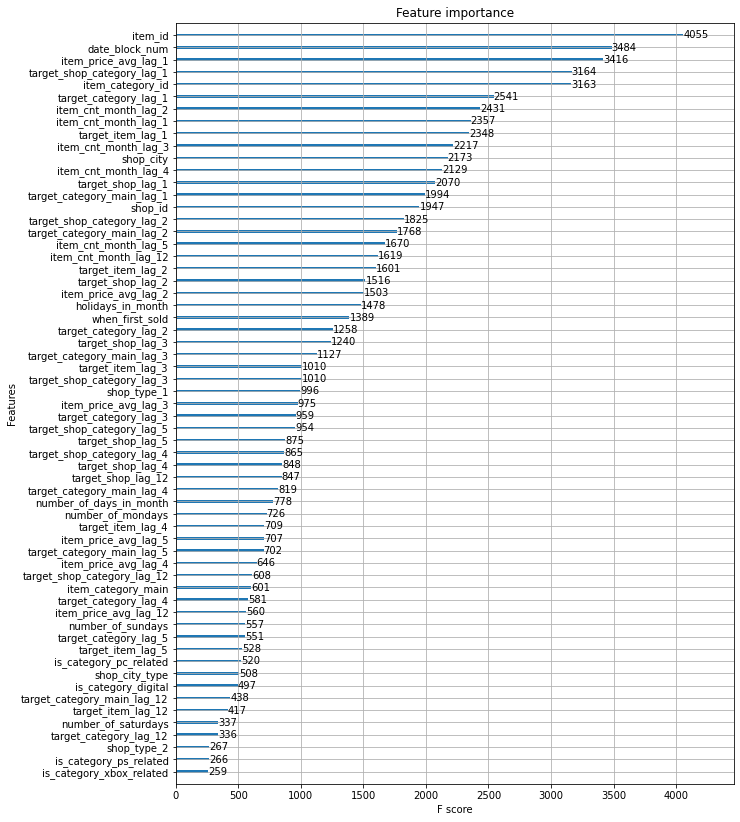

In [35]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(xgb_reg_1, (10, 14))
plt.show()

I ended up using a lot of features in this model. Some works and some don't. Item_id is the most important feature. I consider this a little bit of a failure. I guess I am happy that there are other features quite close like item_price_avg_lag_1 and target_shop_category_lag_1. They are useful to predict items I have not seen before.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

In [49]:
shap_values = shap.TreeExplainer(xgb_reg_1).shap_values(X_train.head(2000))

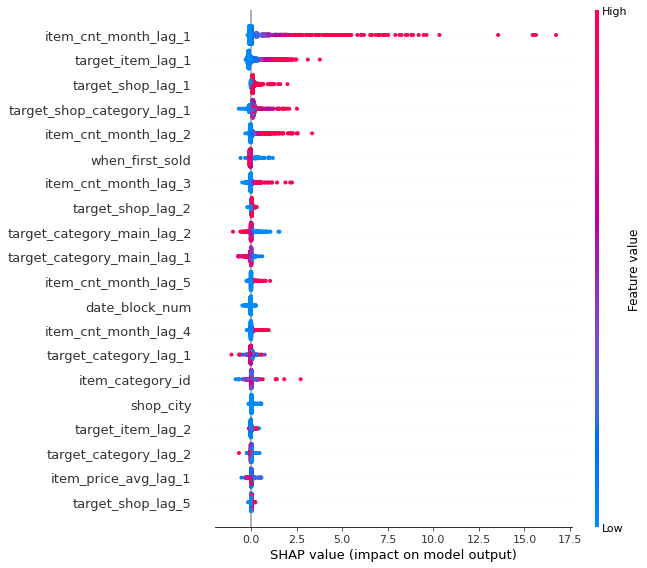

In [50]:
shap.summary_plot(shap_values, X_train.head(2000))

We can see from this visualisation that item_cnt_month_lag_1 account for most of the final value. This makes sense because we expect how often an item was sold last month in the shop to have an impact on this month sales. Similar high value are for 1 month item, shop and shop category. This confirm the value on those features.

# Prepare test data

In [55]:
def create_test_df():

    test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")
    test['date_block_num'] = 34

    # load shops and preprocess it
    shops = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
    shops = fix_shops(shops)  # fix the shops as we have seen before

    # load item_category and preprocess it
    items_category = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
    items_category = fix_item_category(items_category)

    # load items
    items = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
    items.drop(columns = ['item_name'], inplace = True)

    # merge data
    items_to_merge = items.merge(items_category, on = 'item_category_id')
    test_merged = test.merge(shops, on = 'shop_id', how = 'left')
    test_merged = test_merged.merge(items_to_merge, on = 'item_id', how = 'left')

    return test_merged

def add_when_first_sold_to_test(test):
    """ads a 'when_first_sold column to test df'"""
    sales = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
    #sales = remove_outliers(sales)
    first_items_sales = sales.groupby('item_id')['date_block_num'].min()
    test['when_first_sold'] = test['item_id'].map(first_items_sales)
    test['when_first_sold'] = test['date_block_num'] - test['when_first_sold']
    test['when_first_sold'].fillna(0, inplace=True)

    return test

In [56]:
test = create_test_df()
test = add_when_first_sold_to_test(test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [58]:
infile = open(f"all_data_train_with_lag.pickle.dat", "rb")
all_data = pickle.load(infile)
infile.close()

In [61]:
def add_lag(all_data, test):
    index_cols = ['shop_id', 'item_id', 'date_block_num']
    # List of columns that we will use to create lags
    cols_to_rename = ['item_price_avg','item_cnt_month', 'target_shop','target_item', 'target_shop_category','target_category','target_category_main']

    shift_range = [1, 2, 3, 4, 5, 12]

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        test = pd.merge(test, train_shift, on=index_cols, how='left').fillna(0)

        del train_shift
        gc.collect();
    return test
    
test = add_lag(all_data,test)
test['holidays_in_month'] = test['date_block_num'] % 12
holiday_dict = {
    0: 6,
    1: 3,
    2: 2,
    3: 8,
    4: 3,
    5: 3,
    6: 2,
    7: 8,
    8: 4,
    9: 8,
    10: 5,
    11: 4,
}
test['holidays_in_month'] = test['holidays_in_month'].map(holiday_dict)
test = add_days_stat(test)
test = test[features_col]
test = downcast_dtypes(test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
test.head()

date_block_num  holidays_in_month  is_category_digital  \
0              34                  5                    0   
1              34                  5                    0   
2              34                  5                    0   
3              34                  5                    0   
4              34                  5                    0   

   is_category_pc_related  is_category_ps_related  is_category_xbox_related  \
0                       0                       1                         0   
1                       0                       0                         0   
2                       0                       1                         0   
3                       0                       0                         1   
4                       0                       1                         0   

   item_category_id  item_category_main  item_cnt_month_lag_1  \
0                19                   5                   0.0   
1                55                  12                   0.0   
2                19                   5                   1.0   
3                23                   5                   0.0   
4                20                   5                   0.0   

   item_cnt_month_lag_12  item_cnt_month_lag_2  item_cnt_month_lag_3  \
0                    1.0                   1.0                   3.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   3.0                   1.0   
3                    0.0                   0.0                   1.0   
4                    0.0                   0.0                   0.0   

   item_cnt_month_lag_4  item_cnt_month_lag_5  item_id  item_price_avg_lag_1  \
0                   1.0                   1.0     5037                1499.0   
1                   0.0                   0.0     5320                   0.0   
2                   0.0                   2.0     5233                1199.0   
3                   0.0                   0.0     5232                1190.0   
4                   0.0                   0.0     5268                   0.0   

   item_price_avg_lag_12  item_price_avg_lag_2  item_price_avg_lag_3  \
0                 2570.0                 944.5                 896.0   
1                    0.0                   0.0                   0.0   
2                    0.0                 711.5                 712.0   
3                    0.0                 703.5                 642.5   
4                    0.0                   0.0                   0.0   

   item_price_avg_lag_4  item_price_avg_lag_5  number_of_days_in_month  \
0                1491.0                1343.0                       30   
1                   0.0                   0.0                       30   
2                1199.0                 651.0                       30   
3                   0.0                   0.0                       30   
4                   0.0                   0.0                       30   

   number_of_mondays  number_of_saturdays  number_of_sundays  shop_city  \
0                  5                    4                  5          3   
1                  5                    4                  5          3   
2                  5                    4                  5          3   
3                  5                    4                  5          3   
4                  5                    4                  5          3   

   shop_city_type  shop_id  shop_type_1  shop_type_2  target_category_lag_1  \
0               0        5            3            2                 2436.0   
1               0        5            3            2                    0.0   
2               0        5            3            2                 2436.0   
3               0        5            3            2                 2204.0   
4               0        5            3            2                    0.0   

   target_category_lag_12  target_category_lag_2  ta

Verify that tests is created correctly by comparing with previous month

In [63]:
all_data[(all_data.date_block_num == 33) & (all_data.item_id == 5037)& (all_data.shop_id == 5)].head(10)

shop_id  item_id  date_block_num  item_cnt_month  item_price_avg  \
10621988        5     5037              33             0.0          1499.0   

          target_shop  target_item  when_first_sold  shop_type_1  shop_type_2  \
10621988       1014.0         25.0               13            3            2   

          shop_city_type  shop_city  item_category_id  item_category_main  \
10621988               0          3                19                   5   

          is_category_digital  is_category_ps_related  is_category_pc_related  \
10621988                    0                       1                       0   

          is_category_xbox_related  target_category  target_category_main  \
10621988                         0           2436.0               10688.0   

          target_shop_category  item_price_avg_lag_1  item_cnt_month_lag_1  \
10621988                  76.0                 944.5                   1.0   

          target_shop_lag_1  target_item_lag_1  target_shop_category_lag_1  \
10621988             1029.0               85.0                       101.0   

          target_category_lag_1  target_category_main_lag_1  \
10621988                 3500.0                     13168.0   

          item_price_avg_lag_2  item_cnt_month_lag_2  target_shop_lag_2  \
10621988                 896.0                   3.0             1279.0   

          target_item_lag_2  target_shop_category_lag_2  \
10621988              114.0                       137.0   

          target_category_lag_2  target_category_main_lag_2  \
10621988                 4576.0                     14072.0   

          item_price_avg_lag_3  item_cnt_month_lag_3  target_shop_lag_3  \
10621988                1491.0                   1.0              975.0   

          target_item_lag_3  target_shop_category_lag_3  \
10621988               54.0                        64.0   

          target_category_lag_3  target_category_main_lag_3  \
10621988                 3168.0                     11048.0   

          item_price_avg_lag_4  item_cnt_month_lag_4  target_shop_lag_4  \
10621988                1343.0                   1.0              929.0   

          target_item_lag_4  target_shop_category_lag_4  \
10621988              100.0                        71.0   

          target_category_lag_4  target_category_main_lag_4  \
10621988                 3468.0                     12168.0   

          item_price_avg_lag_5  item_cnt_month_lag_5  target_shop_lag_5  \
10621988                1543.0                   1.0              939.0   

          target_item_lag_5  target_shop_category_lag_5  \
10621988               87.0                        75.0   

          target_category_lag_5  target_category_main_lag_5  \
10621988                 3360.0                     11760.0   

          item_price_avg_lag_12  item_cnt_month_lag_12  target_shop_lag_12  \
10621988                 2572.0                    0.0              1125.0   

          target_item_lag_12  target_shop_category_lag_12  \
10621988                64.0                         58.0   

          target_category_lag_12  target_category_main_lag_12  \
10621988                  5080.0                      15792.0   

          number_of_saturdays  number_of_sundays  number_of_mondays  \
10621988                    5                  4                  4   

          number_of_days_in_month  holidays_in_month  
10621988                       31                  8

In [64]:
test[(test.date_block_num == 34) & (test.item_id == 5037)& (test.shop_id == 5)].head(10)

date_block_num  holidays_in_month  is_category_digital  \
0              34                  5                    0   

   is_category_pc_related  is_category_ps_related  is_category_xbox_related  \
0                       0                       1                         0   

   item_category_id  item_category_main  item_cnt_month_lag_1  \
0                19                   5                   0.0   

   item_cnt_month_lag_12  item_cnt_month_lag_2  item_cnt_month_lag_3  \
0                    1.0                   1.0                   3.0   

   item_cnt_month_lag_4  item_cnt_month_lag_5  item_id  item_price_avg_lag_1  \
0                   1.0                   1.0     5037                1499.0   

   item_price_avg_lag_12  item_price_avg_lag_2  item_price_avg_lag_3  \
0                 2570.0                 944.5                 896.0   

   item_price_avg_lag_4  item_price_avg_lag_5  number_of_days_in_month  \
0                1491.0                1343.0                       30   

   number_of_mondays  number_of_saturdays  number_of_sundays  shop_city  \
0                  5                    4                  5          3   

   shop_city_type  shop_id  shop_type_1  shop_type_2  target_category_lag_1  \
0               0        5            3            2                 2436.0   

   target_category_lag_12  target_category_lag_2  target_category_lag_3  \
0                  5964.0                 3500.0                 4576.0   

   target_category_lag_4  target_category_lag_5  target_category_main_lag_1  \
0                 3168.0                 3468.0                     10688.0   

   target_category_main_lag_12  target_category_main_lag_2  \
0                      20272.0                     13168.0   

   target_category_main_lag_3  target_category_main_lag_4  \
0                     14072.0                     11048.0   

   target_category_main_lag_5  target_item_lag_1  target_item_lag_12  \
0                     12168.0               25.0                66.0   

   target_item_lag_2  target_item_lag_3  target_item_lag_4  target_item_lag_5  \
0               85.0              114.0               54.0              100.0   

   target_shop_category_lag_1  target_shop_category_lag_12  \
0                        76.0                         77.0   

   target_shop_category_lag_2  target_shop_category_lag_3  \
0                       101.0                       137.0   

   target_shop_category_lag_4  target_shop_category_lag_5  target_shop_lag_1  \
0                        64.0                        71.0             1014.0   

   target_shop_lag_12  target_shop_lag_2  target_shop_lag_3  \
0              1294.0             1029.0             1279.0   

   target_shop_lag_4  target_shop_lag_5  when_first_sold  
0              975.0              929.0             14.0

In [ ]:
#pickle.dump(test, open(f"test.pickle.dat", "wb"))

# Create submission

In [ ]:
# infile = open(f"test.pickle.dat", "rb")
# test = pickle.load(infile)
# infile.close()

In [65]:
y_pred = xgb_reg_1.predict(test)

In [66]:
 test['item_cnt_month'] = y_pred.clip(0, 20)

In [67]:
def apply_0_to_not_sold_categories(df):

    items = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
    sales_raw = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
    sales_raw = adjust_duplicated_shops(sales_raw)
    merged_df = sales_raw.merge(items[['item_id','item_category_id']], on = 'item_id')

    all_item_categories = list(merged_df['item_category_id'].unique())

    not_available_categories_per_shop = {}

    for shop_id in merged_df['shop_id'].unique():
        shop_item_categories = list(merged_df.loc[merged_df['shop_id'] == shop_id,'item_category_id'].unique())
        not_available_categories_per_shop[shop_id] = list(set(all_item_categories) - set(shop_item_categories))

    counter = 0
    for key, value in not_available_categories_per_shop.items():
        counter += len(df.loc[(df['shop_id'] == key) & (df['item_category_id'].isin(value)), 'item_cnt_month'])
        df.loc[(df['shop_id'] == key) & (df['item_category_id'].isin(value)), 'item_cnt_month'] = 0

    print(counter)
    return df

In [68]:
def correct_submission_for_not_sold_items(test_to_correct):
    """
    function that checks whether particular item_id is still sold in shops.
    arg: path_to_submission_to_improve (str) - path to submission file
         path_to_sales_train (str) - path to sales_train.csv file

    return: corrected_submission (pandas df) - an adjusted submission
    """

    shop_sales = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")

    items_not_sold_in_last_3_months = {}

    test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

    all_test_items = test.item_id.unique()

    for shop_id in test['shop_id'].unique():
        shop = shop_sales.loc[(shop_sales['shop_id'] == shop_id) & (shop_sales['item_id'].isin(all_test_items))]
        shop_items = list(shop['item_id'].unique())
        shop_items_3_months = list(shop.loc[shop['date_block_num'] > 30, 'item_id'].unique())

        items_not_sold_in_last_3_months[shop_id] = list(set(shop_items) - set(shop_items_3_months))

    test_work = test[['ID', 'shop_id', 'item_id']]

    test_work_done = pd.DataFrame()

    for key, value in items_not_sold_in_last_3_months.items():
        test_df = test_work.loc[test_work['shop_id'] == key]
        test_df['coeff'] = 1
        test_df.loc[test_df['item_id'].isin(value),'coeff'] = 0
        test_work_done = pd.concat([test_work_done, test_df], axis = 0)

    test_to_correct_1 = test_to_correct.merge(test_work_done, on = 'ID', how = 'left')

    # test_to_correct_1.fillna(1, inplace=True)

    test_to_correct_1['item_cnt_month'] = test_to_correct_1['item_cnt_month'] * test_to_correct_1['coeff']

    corrected_submission = test_to_correct_1[['ID','item_cnt_month']]

    return corrected_submission

In [69]:
test.head()

date_block_num  holidays_in_month  is_category_digital  \
0              34                  5                    0   
1              34                  5                    0   
2              34                  5                    0   
3              34                  5                    0   
4              34                  5                    0   

   is_category_pc_related  is_category_ps_related  is_category_xbox_related  \
0                       0                       1                         0   
1                       0                       0                         0   
2                       0                       1                         0   
3                       0                       0                         1   
4                       0                       1                         0   

   item_category_id  item_category_main  item_cnt_month_lag_1  \
0                19                   5                   0.0   
1                55                  12                   0.0   
2                19                   5                   1.0   
3                23                   5                   0.0   
4                20                   5                   0.0   

   item_cnt_month_lag_12  item_cnt_month_lag_2  item_cnt_month_lag_3  \
0                    1.0                   1.0                   3.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   3.0                   1.0   
3                    0.0                   0.0                   1.0   
4                    0.0                   0.0                   0.0   

   item_cnt_month_lag_4  item_cnt_month_lag_5  item_id  item_price_avg_lag_1  \
0                   1.0                   1.0     5037                1499.0   
1                   0.0                   0.0     5320                   0.0   
2                   0.0                   2.0     5233                1199.0   
3                   0.0                   0.0     5232                1190.0   
4                   0.0                   0.0     5268                   0.0   

   item_price_avg_lag_12  item_price_avg_lag_2  item_price_avg_lag_3  \
0                 2570.0                 944.5                 896.0   
1                    0.0                   0.0                   0.0   
2                    0.0                 711.5                 712.0   
3                    0.0                 703.5                 642.5   
4                    0.0                   0.0                   0.0   

   item_price_avg_lag_4  item_price_avg_lag_5  number_of_days_in_month  \
0                1491.0                1343.0                       30   
1                   0.0                   0.0                       30   
2                1199.0                 651.0                       30   
3                   0.0                   0.0                       30   
4                   0.0                   0.0                       30   

   number_of_mondays  number_of_saturdays  number_of_sundays  shop_city  \
0                  5                    4                  5          3   
1                  5                    4                  5          3   
2                  5                    4                  5          3   
3                  5                    4                  5          3   
4                  5                    4                  5          3   

   shop_city_type  shop_id  shop_type_1  shop_type_2  target_category_lag_1  \
0               0        5            3            2                 2436.0   
1               0        5            3            2                    0.0   
2               0        5            3            2                 2436.0   
3               0        5            3            2                 2204.0   
4               0        5            3            2                    0.0   

   target_category_lag_12  target_category_lag_2  ta

In [70]:
submission = test.copy()

submission = apply_0_to_not_sold_categories(submission)
submission = submission[['item_cnt_month']].reset_index()
submission.rename(columns={"index": "ID"}, inplace=True)
print('apply_0_to_not_sold_categories ', submission.shape)

# This did not change much
submission = correct_submission_for_not_sold_items(submission)

24136
apply_0_to_not_sold_categories  (214200, 2)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

In [71]:
print('Expect (214200, 2)')
print('Actual ', submission.shape)

Expect (214200, 2)
Actual  (214200, 2)


In [72]:
submission.to_csv('solution_xgboost_with_clip.csv', index=False)

This submission was the best one I was able to achieve

![Best Submission](BestSubmission.png)

I have been working with a team of 3 (InnerPigDog) bouncing ideas and discussing solutions. This was our team second best solution. We had a better solution with a score of 0.91951 that was using LightGbm.  
It has been an incredible experience and I feel like I've learned a lot and definetly I have reached my learning goals for this online training.  
In these last few days, I've tried to understand better Target encoding. I didnt manage to improve the score but I was happy with the learning.  
With more times we would definetly try stacking techniques. I am also interested in different kind of encodings but myself and the team decided to close this chapter and moving to a different challenge.

Thank you for reading,  
Tullio